# Tutorial 4: Ocean wind driven circulation

**Week 1, Day 2: State of the Climate - Ocean and Atmospheric Reanalysis**
**By Neuromatch Academy**

__Content creators:__   Abigail Bodner,   Day Lead's Name

**Content reviewers:** Katrina Dobson, Danika Gupta, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Ohad Zivan

**Content editors:** Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS

# Tutorial Objectives

The ocean's motion is driven by radiation from the sun, winds, and various sources of fresh water  (precipitation, rivers, melting and freezing ice). In the previous tutorial, we measured the surface winds around the world. The surface winds impose at the surface of the ocean which results in ocean transport, known as Ekman transport. In this tutorial, we are going to use [Estimating the Circulation and Climate of the Ocean (ECCO)](https://www.ecco-group.org/) dataset, to make the best possible estimates of ocean circulation and its role in climate.

At the end of this tutorial you will be able to 

- access and select ocean reanalysis data data 
- plot average surface currents 
- compare with global winds from a previous tutorial

# Setup

In [1]:
#from intake import open_catalog
import matplotlib.pyplot as plt
import matplotlib
import ipywidgets as widgets       # interactive display
from IPython.display import IFrame
import os
import pooch

import numpy as np
import xarray as xr
import warnings
from cartopy import crs as ccrs, feature as cfeature
#  Suppress warnings issued by Cartopy when downloading data files
warnings.filterwarnings('ignore')

In [2]:
# plot helping function

def set_projection_figure(projection = ccrs.PlateCarree(), figsize =(5, 4.5) ):
    # source:https://foundations.projectpythia.org/core/cartopy/cartopy.html

    projLccNY =  projection #ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

    fig = plt.figure(figsize=figsize)
    ax = plt.subplot(1, 1, 1, projection=projLccNY)

    format_axes(ax)
    #ax.add_feature(cfeature.STATES)
    #ax.add_feature(cfeature.RIVERS)
    return fig, ax

def format_axes(ax):
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='None', alpha=0.3 )
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='black', alpha=0.5, linestyle='--')
    gl.xlocator = matplotlib.ticker.MaxNLocator(7)
    gl.ylocator = matplotlib.ticker.MaxNLocator(5)
    gl.xlabels_top  = False
    gl.ylabels_left = False
    #gl.xlines = False

# helping functions:
def geographic_lon_to_360(lon):
    return 360 + lon

def inverted_geographic_lon_to_360(lon):
    return lon - 180

def cbar_label(DD):
    return DD.attrs['long_name'] + ' [' + DD.attrs['units']+ ']'


In [3]:
# @title Figure settings
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")


def font_for_print():

    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 11
    legend_properties = {'weight':'bold'}

    plt.rc('font', size=SMALL_SIZE, serif='Helvetica Neue', weight='normal')          # controls default text sizes
    #plt.rc('font', size=SMALL_SIZE, serif='DejaVu Sans', weight='light')
    plt.rc('text', usetex='false')
    plt.rc('axes', titlesize=MEDIUM_SIZE, labelweight='normal')     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE, labelweight='normal') #, family='bold')    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE, frameon=False)    # legend fontsize
    plt.rc('figure', titlesize=MEDIUM_SIZE, titleweight='bold', autolayout=True) #, family='bold')  # fontsize of the figure title

    plt.rc('axes', labelsize= SMALL_SIZE, labelweight='normal')

font_for_print()

Load atmospheric (ERA5) and oceanic (ECCO) reanalysis data 



In [5]:
#ERA5 data loading - same data from tutorial 3 part 2
url = "https://osf.io/3q4vs/download" # contains only one file: 'ERA5_surface_winds_mm.nc'
ERA5=xr.open_dataset(pooch.retrieve(url, known_hash=None)).sel(time=slice('1980', '2010'))
ERA5

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 312)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2005-12-01
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    si10       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-04-06 23:25:45 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [28]:
#Surface data loading
fname_surface = 'surface_eval.nc'
url_surface = "https://osf.io/46e35/download"
ECCO_U = xr.open_dataarray(pooch.retrieve(url_surface, known_hash=None, fname=fname_surface))
ECCO_U

SHA256 hash of downloaded file: afa140218e7915ea6244b8426632c6eee413f0b77f9e012725c21aa039eff73b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


<xarray.DataArray 'EVEL' (latitude: 360, longitude: 720)>
[259200 values with dtype=float64]
Coordinates:
    i          (longitude) int64 ...
    k          int64 ...
    j          (latitude) int64 ...
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
    Z          float32 ...

In [7]:
fname_surface_nvel = 'surface_nvel.nc'
url_surface_nvel = "https://osf.io/v6mzq/download"
ECCO_V = xr.open_dataset(pooch.retrieve(url_surface_nvel, known_hash=None, fname=fname_surface_nvel))
ECCO_V

<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 360)
Coordinates:
    i          (longitude) int64 ...
    k          int64 ...
    j          (latitude) int64 ...
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
    Z          float32 ...
Data variables:
    NVEL       (latitude, longitude) float64 ...

Examine the time ranges of each dataset

In [8]:
print('The time range is:')
print( ERA5.time[0].data.astype('M8[h]') , 'to', ERA5.time[-1].data.astype('M8[h]') )

The time range is:
1980-01-01T00 to 2005-12-01T00


List the available *time* data from a specific year (2018) to identify the *output frequency* or *temporal frequency*, which is the rate at which reanalysis data is provided.

In [9]:
ERA5.time.sel(time='2000')

<xarray.DataArray 'time' (time: 12)>
array(['2000-01-01T00:00:00.000000000', '2000-02-01T00:00:00.000000000',
       '2000-03-01T00:00:00.000000000', '2000-04-01T00:00:00.000000000',
       '2000-05-01T00:00:00.000000000', '2000-06-01T00:00:00.000000000',
       '2000-07-01T00:00:00.000000000', '2000-08-01T00:00:00.000000000',
       '2000-09-01T00:00:00.000000000', '2000-10-01T00:00:00.000000000',
       '2000-11-01T00:00:00.000000000', '2000-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2000-12-01
Attributes:
    long_name:  time

## Discussion
- Why do you think the atmospheric dataset have higher output frequency than the ocean dataset?
- What can we infer about the rate of change of the two systems and their role in the climate system from these output frequencies?
- What type of averaging do we need to perform on ERA5 in order to compare directly with ECCO?

In [2]:
# to_remove explanation

print (""" 
1. The atmospheric dataset typically has a higher output frequency than the ocean dataset due to the different timescales on which the atmosphere and the ocean respond to changes. The atmosphere is more volatile and can change rapidly over minutes to hours, while the ocean, due to its high thermal inertia and slower currents, changes more slowly.
2. atmosphere plays a faster, more immediate role in the climate system. It reacts quickly to heat and pressure differences, driving weather changes. The ocean, on the other hand, plays a longer-term role in the climate system and provides a buffering effect against rapid atmospheric changes.
3. To compare the ERA5 atmospheric dataset directly with the ECCO ocean dataset, we would need to perform temporal averaging on the ERA5 data to match the output frequencies. For example, computing monthly averages from the higher-frequency atmospheric data to match the output frequency of the ECCO dataset.
""")


 
1. The atmospheric dataset typically has a higher output frequency than the ocean dataset due to the different timescales on which the atmosphere and the ocean respond to changes. The atmosphere is more volatile and can change rapidly over minutes to hours, while the ocean, due to its high thermal inertia and slower currents, changes more slowly.
2. atmosphere plays a faster, more immediate role in the climate system. It reacts quickly to heat and pressure differences, driving weather changes. The ocean, on the other hand, plays a longer-term role in the climate system and provides a buffering effect against rapid atmospheric changes.
3. To compare the ERA5 atmospheric dataset directly with the ECCO ocean dataset, we would need to perform temporal averaging on the ERA5 data to match the output frequencies. For example, computing monthly averages from the higher-frequency atmospheric data to match the output frequency of the ECCO dataset.



## Surface currents compared with surface winds 

- Slides about wind driven circulation and introducing the ECCO model


# Section 1: Plotting global surface winds using ERA5 

Now let's plot global maps of surface winds, averaged over a month that is present in the time ranges of both ECCO and ERA5. Fortunately, we can use a similar computation to the previous tutorial!



In [11]:
# Pick a month that overlaps between ERA5 and ECCO. Here we choose April 2000
year_month = '2000-04'

#examine the time array within this temporal selection
ERA5.sel(time=year_month).time

<xarray.DataArray 'time' (time: 1)>
array(['2000-04-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2000-04-01
Attributes:
    long_name:  time

We can compare the ERA5 directly to the ECCO monthly data. We then select the atmospheric variables of interest, the 10 meter wind speeds in the zonal and meridional directions.

In [18]:
# select year and month of interest and take average over all days in month
ERA5_monthly_mean= ERA5.sel(time=year_month).mean('time') 
# this is only 1 month, but the mean removes the time dimension from the dataset

# zonal 10m wind speed
ERA_U = ERA5_monthly_mean['u10']
# meridional 10m wind speed
ERA_V = ERA5_monthly_mean['v10']

In [19]:
ERA5_monthly_mean

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Data variables:
    u10        (latitude, longitude) float32 -0.08544 -0.08544 ... 0.5329 0.5329
    v10        (latitude, longitude) float32 0.04284 0.04284 ... 0.08904 0.08904
    si10       (latitude, longitude) float32 5.973 5.973 5.973 ... 5.509 5.509

Rather than ploting the zonal and meridional velocity components $(u,v)$ separately, we will plot the magnitude and direction of the total velocity vector. This type of plot is called a vector field. A [vector](https://glossary.ametsoc.org/wiki/Vector) is a special mathematical quantity that has both a magnitude and a direction, just like the wind! The velocity components describe how much wind is blowing in the zonal ($u$) or meridional ($v$) directions. Specifically, wind can blow in the eastward (positive $u$) or westward (negative $u$) direction, and in the northward (positive $v$) or southward (negative $v$) direction. The total velocity vector is the *vector sum* of these two components, and has variable magnitude and direction. The magnitude ($||u||)$ and direction ($\theta$) of the total velocity vector are given by

\begin{align}
||u|| = \sqrt{u^2 + v^2},  \ \  \ \ \theta = tan^{-1}(\frac{v}{u})
\end{align}

When using a computer to plot a vector field, it is usually called a quiver plot instead. We will use a [quiver function created by Ryan Abernathey](https://rabernat.github.io/intro_to_physical_oceanography/07_ekman.html) that derives the magnitude and direction of the total velocity vector from the given zonal and meridional components.

In [20]:
# make sure to credit Ryan Abernathey here
def quiver_ERA(u, v, sampling_x=10, sampling_y=10, mag_max=None, **kwargs):

    x = u.longitude
    y = u.latitude

    # calculate magnitude of total velocity
    mag = (u**2 + v**2)**0.5

    # coarsen the grid so the arrows are distinguishable by only selecting
    # some longitudes and latitudes defined by sampling_x and sampling_y.
    slx = slice(None, None, sampling_x)
    sly = slice(None, None, sampling_y)
    sl2d = (sly, slx)

    #fig, ax = plt.subplots(**kwargs)
    fig, ax = set_projection_figure(projection = ccrs.PlateCarree(), figsize = (9, 5.5) )

    # plot contours of the magnitude
    ax.contourf(x,y,mag, vmax=mag_max, cmap='Blues_r')

    #plt.colorbar(fig, orientation='vertical', label = 'm/s', shrink= 0.55 , pad = 0.08)

    #return the quiver plot just at the locations we sampled
    return ax, ax.quiver(x[slx], y[sly], u[sl2d], v[sl2d])

(<GeoAxes: >, <matplotlib.quiver.Quiver at 0x1b3e2b98730>)

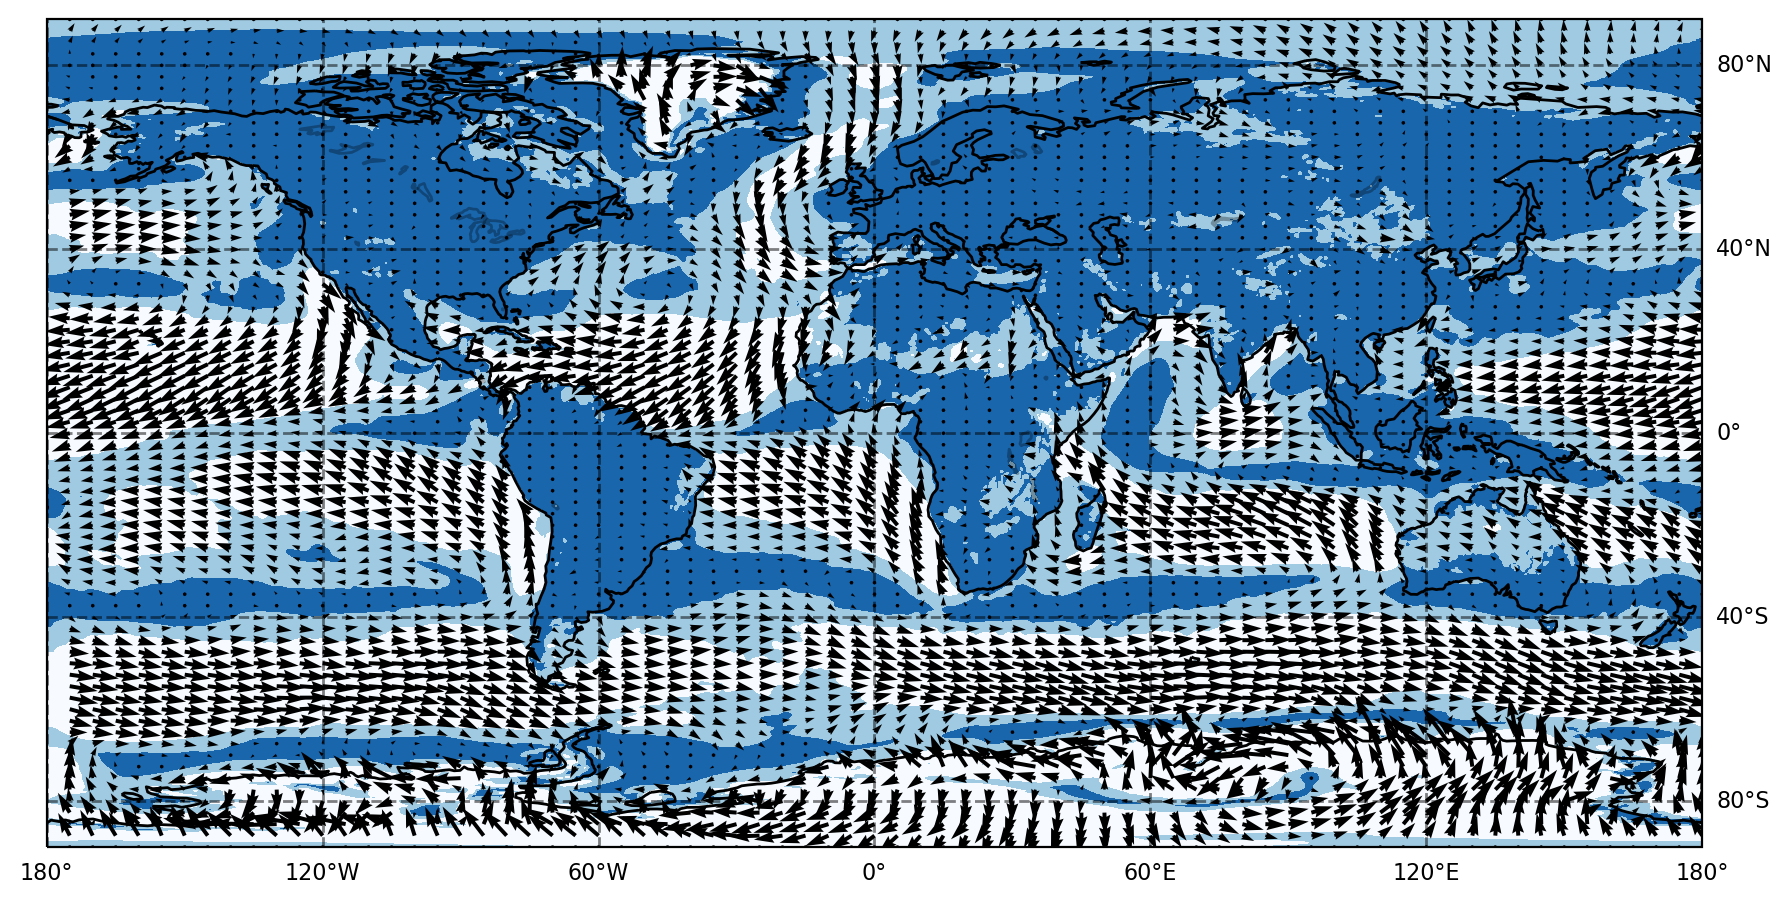

In [21]:
# plot magnitude of wind speed overlayed by quiver arrows indicating vector direction
# Note this one takes a little while

# we define contours levels that will be used in all plots the compare them better
colorlevels = np.arange(0, 10, 2)


quiver_ERA(ERA_U, ERA_V,
             mag_max=6, sampling_x=20, figsize=(16,8))
#plt.title('Date '+year_month +' | qrt(U^2 + V^2) ',loc ='left')

# Section 2: Plotting global surface currents using ECCO 

To understand how the near-surface winds impact the ocean's motion, we will examine surface currents from [ECCO (Estimating the Circulation and Climate of the Ocean)](https://www.ecco-group.org) reanalysis and compare these to the atmosphere.

First let us look at the ECCO dataset variables

We next compute the time mean in the same manner as before. We also are only interested in the surface values so we select $k=0$, which represents the upper most layer of the ocean near the surface.

Now let us examine ECCO_U and ECCO_V 

In [38]:
ECCO_V

<xarray.DataArray 'NVEL' (latitude: 360, longitude: 720)>
array([[0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       ...,
       [0.00911 , 0.00911 , 0.00911 , ..., 0.00911 , 0.00911 , 0.00911 ],
       [0.008443, 0.008443, 0.008443, ..., 0.008443, 0.008443, 0.008443],
       [0.013739, 0.013739, 0.013739, ..., 0.013739, 0.013739, 0.013739]])
Coordinates:
    i          (longitude) int64 ...
    k          int64 ...
    j          (latitude) int64 ...
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
    Z          float32 ...

In [26]:
ECCO_U

<xarray.DataArray 'EVEL' (latitude: 360, longitude: 720)>
[259200 values with dtype=float64]
Coordinates:
    i          (longitude) int64 ...
    k          int64 ...
    j          (latitude) int64 ...
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
    Z          float32 ...

The only dimensions now $['j', 'i_g']$ for $U$, $['j_g', 'i']$ for $V$, and $['face']$ for both. These are related to how velocity variables are computed and stored in the ECCO model. Here $'face'$ refers to the tiles of the [grid for this particular model](https://xgcm.readthedocs.io/en/latest/grid_topology.html), which are not regular.


Let's examine what the zonal ocean velocity (ECCO_u) looks like for each tile of our model

In [27]:
# ECCO_U.plot(col='face', col_wrap=5)

KeyError: 'face'

Each face represents a different section within the globe. It is possible to manually "patch" these together but we will interpolate U and V to a regular lat-lon grid using a [handy package](httpshttps://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Interpolating_Fields_to_LatLon_Grid.html://) developed specifically to make it easier to work with the ECCO model!


In [31]:
import ecco_v4_py as ecco

In [ ]:
ECCO_V

In [33]:
# interpolate the zonal and meridional velocities
# ECCO_U_interp = ECCO_U.interp(i_g=ECCO_U.i)
# ECCO_V_interp = ECCO_V.interp(j_g=ECCO_V.j)

# plot
# ecco.plot_proj_to_latlon_grid(ECCO.XC, ECCO.YC, 0.5*(ECCO_U_interp**2+ECCO_V_interp**2)**0.5, cmap='Blues_r', vmax=6);

ValueError: Dimensions {'i_g'} do not exist. Expected one or more of Frozen({'longitude': 720, 'latitude': 360})

Now let us add the surface winds quiver plot overlayed on top of surface surrents

In [46]:
# make sure to credit Ryan Abernathey here
def quiver_ERA_ECCO(u, v, sampling_x=10, sampling_y=10, mag_max=None, **kwargs):
    x = u.longitude
    y = u.latitude
    mag = 0.5*(u**2 + v**2)**0.5
    slx = slice(None, None, sampling_x)
    sly = slice(None, None, sampling_y)
    sl2d = (sly, slx)

    fig, ax = set_projection_figure(projection = ccrs.PlateCarree(), figsize = (9, 5.5) )

    # plot contours of the magnitude
    ax.contourf(x,y,mag, vmax=mag_max, cmap='Blues_r')

    #fig, ax = plt.subplots(**kwargs)
    #fig, ax = set_projection_figure(projection = ccrs.PlateCarree(), figsize = (9, 5.5) )
    #ax.contourf(x,y,mag, vmax=mag_max, cmap='Blues_r')
    #plt.colorbar(fig, orientation='vertical', label = 'm/s', shrink= 0.55 , pad = 0.08)
    return ax, ax.quiver(x[slx], y[sly], u[sl2d], v[sl2d])

(<GeoAxes: >, <matplotlib.quiver.Quiver at 0x1b3ef1fdcc0>)

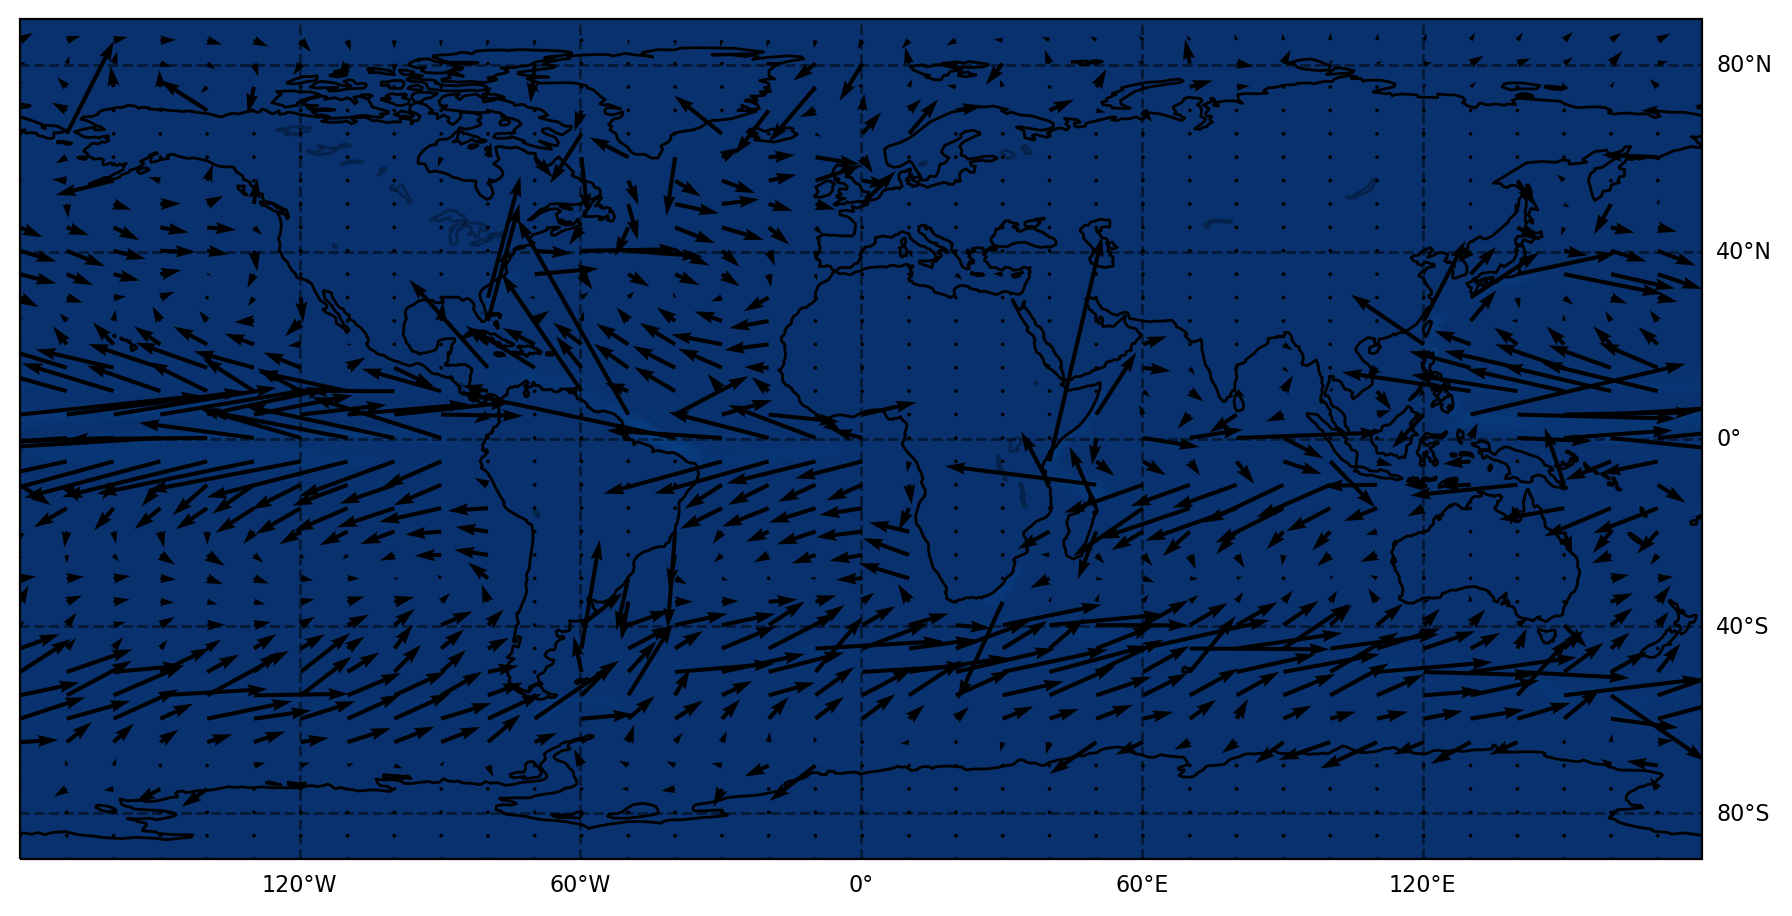

In [47]:
quiver_ERA_ECCO(ECCO_U, ECCO_V.NVEL,
             mag_max=6, sampling_x=20, figsize=(16,8))


In [41]:
ECCO_V

<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 360)
Coordinates:
    i          (longitude) int64 ...
    k          int64 ...
    j          (latitude) int64 ...
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
    Z          float32 ...
Data variables:
    NVEL       (latitude, longitude) float64 0.0 0.0 0.0 ... 0.01374 0.01374

In [35]:
fig = ecco.plot_proj_to_latlon_grid(ECCO_U.longitude, ECCO_U.latitude, 0.5*(ECCO_U**2+ECCO_V**2)**0.5,
                              cmap='Blues_r', vmax=6, projection_type = 'PlateCarree');

ValueError: Unsupported key-type <class 'slice'>

**SOMETHING WENT WRONG-- CAN'T OVERLAY WIND QUIVER PLOT !!**

In [ ]:
# #fig, ax = set_projection_figure(projection = ccrs.PlateCarree(), figsize = (9, 5.5) )
# fig, ax = plt.subplots()
# ecco.plot_proj_to_latlon_grid(ECCO.XC, ECCO.YC, 0.5*(ECCO_U_interp**2+ECCO_V_interp**2)**0.5,
#                               cmap='Blues_r', vmax=6, projection_type = 'PlateCarree');

# sampling_x=20
# sampling_y=20
# x = ERA_U.longitude
# y = ERA_V.latitude
# slx = slice(None, None, sampling_x)
# sly = slice(None, None, sampling_y)
# sl2d = (sly, slx)

# ax.quiver(x[slx], y[sly], ERA_U[sl2d], ERA_V[sl2d])

# plt.show()

As a final step let us compare with the surface wind magnitude and direction.

#### *A few notes:*
- **Surprise fact!** The wind driven currents at the surface are not actually in the direction of the wind but rather at a ~45 degree angle. This is known as the Ekman pumping effect, for which water is either upwelled or downwelled based on the directionality of the wind. Can you notice this relationship?
- **Fun fact!** Upwelling and downwelling is actually a very important process in the El Nino phenomena we discussed earlier. The El Nino La Nina phase is identified either strong or week upwelling near the coast. .. add here story of Fisherman along the coast of Peru and why it is named El Nino.

Next activity: can you plot the coast of Peru and examine the direction of the wind and the direction of the ocean currents?

Let's make the same plot with surface temperature? What is the relationship between wind, upwelling, and temperature in this location? (make connection here to next tutorial on density)

Bonus activity! Try to repeat the steps above with different months and years. Can you identify an El Nino or La Nina event?

Zooming back out, does the wind driven circulation does not explain all of the ocean currents? What do you think is missing? In the next tutorial you will discuss density driven currents

---
# Summary




In this tutorial, we've delved into the mechanisms that shape ocean currents, specifically the role of wind in driving these currents. We've explored the concept of "*surface stress*", a frictional force created by wind across the water surface, initiating the movement of ocean currents. We've further examined the intricacies of "*wind-driven circulation*", a system whereby ocean currents are predominantly powered by surface winds, influencing global climate and biogeochemical cycles. Utilizing the ECCO dataset, we've also gained practical skills in accessing and analyzing ocean reanalysis data.
